# Building a CG Model of the Miniprotein Chignolin

Chignolin is a miniprotein that is ten amino acids long. The variant CLN025 in particular shows three metastable molecular states, corresponding to folded, misfolded, and unfolded conformations. To build a CG force field for coarse grain molecular dynamics through force matching, we must first download and prepare a dataset in order to train our neural network. The dataset that we choose is composed of 3744 all-atom simulations of CLN025 at 350K using CHARMM22* via an adaptive sampling strategy. The data is publicly available at http://pub.htmd.org/chignolin_trajectories.tar.gz .

For convenience, we have provided an example `torch_geometric.data.InMemoryDataset` class that automatically downloads, unzips, and organizes the data. Once the data is organized, the all-atom
coordinates and forces are mapped to a 10 bead carbon alpha coarse grained representation. Using the mapped coordinate data, a baseline prior model according to [CGSchNet](https://doi.org/10.1063/5.0026133) is parametetrized
and used to subtract baseline coarse grain forces from the total coarse grain forces. The resulting "delta forces" can then be used as supervised learning targets for training coarse grain force
field models through force matching.



## Loading the CLN025 Dataset

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import torch
import sys
import os.path as osp

In [4]:
sys.path.insert(0, "../../")
from mlcg.datasets import ChignolinDataset
from mlcg.pl import merge_priors_and_checkpoint
from mlcg.utils import load_yaml, dump_yaml

# Load the dataset

To download and process the data, we supply a path when instantiating the dataset. The coordinates, forces, topology, and other important information will be organized and stored in this directory. In total, the raw (all-atom) dataset is about ~14 GB, while the CG dataset only occupies about ~1.2 GB in memory:

In [5]:
root = "PATH/TO/STORE/THE/DATASET"
root = "/net/data02/nickc/mlcg_cln"
dataset = ChignolinDataset(root)

With the dataset downloaded and processed, we can take a closer look:

In [6]:
print("CG mapped data:\n\n", dataset.data)

CG mapped data:

 AtomicData(
  out={},
  pos=[18688610, 3],
  traj_id=[1868861],
  name=[1868861],
  frame_id=[1868861],
  atom_types=[18688610],
  n_atoms=[1868861],
  masses=[18688610],
  forces=[18688610, 3],
  neighbor_list={}
)


Altogether, we have an aggregate ~1.8M frames of trajectory data (for both coordinates and forces). The collated data also contains information about the masses and the neighborlists associated with the features of the baseline/prior model (see below). We can also visualize how the different CG beads are typed. `mlcg.geometry.topology` contains several useful tools for graph related operations. Here, we use `get_connectivity_matrix` to generate a connectivity/adjacency matrix associated with the bonded structure of our CG mapping of Chignolin. This matrix can be used directly with `networkx`:

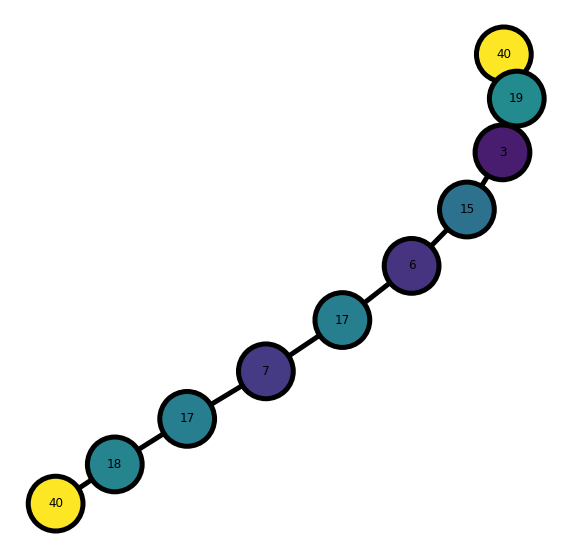

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
dataset.topologies['cln'].draw(
    layout_kwargs={"seed": 7},
    drawing_kwargs={
        "node_size": 3000,
        "width": 5,
        "edgecolors": "black",
        "ax": ax,
        "linewidths": 5,
    },
)

Here, we see that integer type have been assigned to each of the 10 carbon alpha atoms according to its amino acid identity, while allocating special types for the terminal TYR1 and TYR10 carbon alpha atoms. Because Pytorch Geometric is built upon `networkx`, there are several other graph analysis functions that are of general use in the `mlcg.geometry.topology` module. We can also inspect the baseline model that produced the delta forces that will be used for training the model describing the CG forcefeild:

In [10]:
print(dataset.prior_models)

ModuleDict(
  (bonds): GradientsOut(
    (model): HarmonicBonds()
  )
  (angles): GradientsOut(
    (model): HarmonicAngles()
  )
  (repulsion): GradientsOut(
    (model): Repulsion()
  )
)


We see that our baseline model contains three prior types, which are defined in `mlcg.nn.prior`: `HarmonicBonds` to constrain sequential carbon alpha pairs and `HarmonicAngles` to constrain sequential carbon alpha triplets along the molecular backbone. These two priors keep the CG molecule from breaking apart or becoming too flexible. The baseline model also employs a `Repulsion` prior to all non-bonded carbon alpha atoms, which helps to prevent distant parts of the CG molecule from overlapping or collapsing on itself. When an `AtomicData` instance is forwarded through a prior, it must contain information in the `neighborlist` attribute so that the corresponding features (eg, distances or angles) can be computed from the coordinates (for more on this, see the simulation section below!).

# Training a Model 

With the dataset downloaded and processed, we can now build and train a model to predict CG forces and energies. For our model, we choose CGSchNet, based on [CGSchNet](https://doi.org/10.1063/5.0026133). CGSchNet is an extended version of the SchNet graph neural network architecture for CG molecular systems. It accepts coordinates (specifically pairwise distances) and CG atom types as model inputs, and predicts CG energies and cartesian forces that can later be used for generative CG simulation. 

To train the model, normally, we use PyTorch Lightning CLI, which removes training boiler plate code/scripts by using training and model parameters specified entirely in a configuration `YAML` file. If users wish to make more general models, or if they prefer to implement their own training routines, all neural network and prior utilities are contained in the `mlcg.nn` subpackage. Here, we explicitly build a model from scratch to showcase both structure and flexibility:

In [11]:
# directory used to save training informations
TRAIN_PATH = osp.abspath("./train/")
!mkdir $TRAIN_PATH

## Training in the Notebook

### radial basis

For a SchNet model, we must first choose our Radial basis and Cutoff functions for the filter generating network. For this example, we choose `ExpNormalBasis` based on the PhysNet-style RBFs introduced in [Physnet](https://doi.org/10.1021/acs.jctc.9b00181). Since this basis already contains a `CosineCutoff` envelope, we simply use `IdentityCutoff` for our cutoff function. We can directly visualize our basis using tools from `mlcg.nn.radial_basis`:

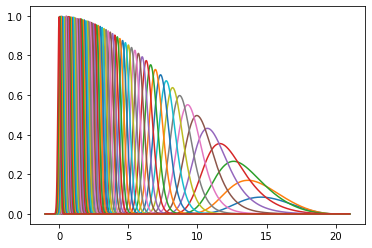

In [12]:
from mlcg.nn.radial_basis import ExpNormalBasis
from mlcg.nn.cutoff import CosineCutoff

cutoff_lower = 0.00
cutoff_upper = 20.00
num_rbf = 64

cutoff_fn = CosineCutoff(cutoff_lower=cutoff_lower, cutoff_upper=cutoff_upper)
rbf_layer = ExpNormalBasis(cutoff=cutoff_upper, num_rbf=64)
rbf_layer.plot()

### SchNet model

We can see that our basis offers higher filter resolution at smaller distances, while larger distances the filter resolution is more broad and the natural response is weaker. Next, we are ready to make our full SchNet enegy model. Although we have the freedom to assemble more modular constructions through the use of the `SchNet` class, we will instead use a convenient subclass called `StandardSchNet` that only requires the user to supply a cutoff and an RBF layer. The remaining options can be specified through keyword arguments.

In [13]:
from mlcg.nn import StandardSchNet

schnet_params = {
    "max_num_neighbors": 50,
    "embedding_size": 44,
    "num_interactions": 3,
    "num_filters": 128,
    "hidden_channels": 128,
    "output_hidden_layer_widths": [128, 128],
    "activation": torch.nn.Tanh(),
    "aggr": "add",
}

energy_model = StandardSchNet(rbf_layer, cutoff_fn, **schnet_params)
print(energy_model)

StandardSchNet(
  (embedding_layer): Embedding(44, 128)
  (rbf_layer): ExpNormalBasis(
    (cutoff): CosineCutoff()
  )
  (interaction_blocks): Sequential(
    (0): InteractionBlock(
      (conv): CFConv()
      (activation): Tanh()
      (lin): Linear(in_features=128, out_features=128, bias=True)
    )
    (1): InteractionBlock(
      (conv): CFConv()
      (activation): Tanh()
      (lin): Linear(in_features=128, out_features=128, bias=True)
    )
    (2): InteractionBlock(
      (conv): CFConv()
      (activation): Tanh()
      (lin): Linear(in_features=128, out_features=128, bias=True)
    )
  )
  (output_network): MLP(
    (layers): Sequential(
      (0): Linear(in_features=128, out_features=128, bias=True)
      (1): Tanh()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): Tanh()
      (4): Linear(in_features=128, out_features=1, bias=True)
    )
  )
)


Our SchNet model can predict scalar energies for each example/structure passsed to it in a batch of data. These energies are stored in the `out` field of an `AtomicData` instance that passes through the energy model. In this way, it is natural to think of models as objects that update `AtomicData` instances (by populating them with new attributes/predictions). However, to train our model using force matching we must extract CG forces from the predicted CG energies through a gradient operation. To achieve this, we wrap our SchNet model with a `GradientsOut` object. `GradientsOut` simply requires an energy model and a list of prediction targets that can be acquired through gradient operations. In this case, we specify our gradient wrapper to calculate the CG forces. In pricple, any model can be wrapped by any operation, as data outputs are always stored in `AtomicData.out`, so it is possible to retreive higher order gradients or transform the energy into other physical properties:

In [14]:
from mlcg.nn.gradients import GradientsOut

full_model = GradientsOut(energy_model, targets=["forces"])
print(full_model)

GradientsOut(
  (model): StandardSchNet(
    (embedding_layer): Embedding(44, 128)
    (rbf_layer): ExpNormalBasis(
      (cutoff): CosineCutoff()
    )
    (interaction_blocks): Sequential(
      (0): InteractionBlock(
        (conv): CFConv()
        (activation): Tanh()
        (lin): Linear(in_features=128, out_features=128, bias=True)
      )
      (1): InteractionBlock(
        (conv): CFConv()
        (activation): Tanh()
        (lin): Linear(in_features=128, out_features=128, bias=True)
      )
      (2): InteractionBlock(
        (conv): CFConv()
        (activation): Tanh()
        (lin): Linear(in_features=128, out_features=128, bias=True)
      )
    )
    (output_network): MLP(
      (layers): Sequential(
        (0): Linear(in_features=128, out_features=128, bias=True)
        (1): Tanh()
        (2): Linear(in_features=128, out_features=128, bias=True)
        (3): Tanh()
        (4): Linear(in_features=128, out_features=1, bias=True)
      )
    )
  )
)


### Setting up the actual training

Next, to train our model, we can use Pytorch Lighning utilities `PLModel` and `DataModule`, which handle optimization of the model parameters and migration of data from the dataset to the model respectively. The former requires a loss function and a pytorch optimizer class path. For the loss function, we choose `ForceRMSE`, which reports the root-mean-square error between predicted CG forces and reference forces. The `DataModule` accepts our Chignolin dataset instanced above. In order to save time, we stride the training data by a factor of 1000 (though this will obviously result in reduced accuracy in the trained model):

In [15]:
import pytorch_lightning as pl
from mlcg.nn.losses import ForceRMSE
from mlcg.pl import PLModel, DataModule

loss_fn = ForceRMSE("forces")
pl.seed_everything(12659843)
optimizer_dict = {"class_path": "torch.optim.Adam", "init_args": {"lr": 5e-4}}
lr_scheduler = {
    "class_path": "torch.optim.lr_scheduler.ReduceLROnPlateau",
    "init_args": {
        "factor": 0.9,
        "patience": 10,
        "min_lr": 1e-5,
    },
}
plmodel = PLModel(full_model, loss_fn, optimizer_dict, lr_scheduler, monitor='validation_loss')
dm = DataModule(dataset, log_dir=TRAIN_PATH, loading_stride=1000, num_workers=3)

Global seed set to 12659843


We can now combine our `PLModel` and `DataModule` by using the Pytorch Lightning `Trainer` object. `Trainer`can be supplied with callbacks, schedulers, etc. The `Trainer` can also take advantage of useful logging tools such as TensorBoard (or several other third party loggers). For this example, we choose to train only using the CPU, but it is very simple to specify GPU training by chaning the accelerator:

In [16]:
from pytorch_lightning.callbacks import LearningRateMonitor, EarlyStopping
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint


checkpoint_callback = ModelCheckpoint(
    dirpath=TRAIN_PATH,
    monitor="validation_loss",
    save_top_k=-1,  # -1 to save all
    every_n_epochs=1,
    filename="{epoch}-{validation_loss:.4f}",
    save_last=True,
)

lr_monitor = LearningRateMonitor(logging_interval="epoch")
early_stopping = EarlyStopping(
    monitor="validation_loss", patience=10, min_delta=5e-2
)
tb_logger = pl.loggers.TensorBoardLogger(
    TRAIN_PATH, name="tensorboard", version=""
)
csv_logger = pl.loggers.CSVLogger(TRAIN_PATH, name="", version="")

trainer = pl.Trainer(
    max_epochs=20,
    accelerator="cpu",
    devices=1,
    precision=32,
    auto_lr_find=False,
    enable_checkpointing=True,
    callbacks=[checkpoint_callback, lr_monitor, early_stopping],
    logger=[tb_logger, csv_logger],
    log_every_n_steps=1,
    reload_dataloaders_every_epoch=False,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


We can begin training our model by calling the `Trainer.fit()` method and supplying our `PLModel` and `DataModule`:

In [17]:
from time import ctime

print(f"Starting training at {ctime()}")
trainer.fit(plmodel, dm)
print(f"Ending training at {ctime()}")

Starting training at Mon Mar 21 11:57:39 2022


/home/user/.local/lib/python3.9/site-packages/pytorch_lightning/loggers/csv_logs.py:57: UserWarning: Experiment logs directory /home/user/Work/mlcg/mlcg-tools/examples/notebooks/train/ exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  rank_zero_warn(

  | Name  | Type         | Params
---------------------------------------
0 | model | GradientsOut | 261 K 
1 | loss  | ForceRMSE    | 0     
---------------------------------------
261 K     Trainable params
0         Non-trainable params
261 K     Total params
1.047     Total estimated model params size (MB)
/home/user/.local/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /home/user/Work/mlcg/mlcg-tools/examples/notebooks/train exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 12659843


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Ending training at Mon Mar 21 12:02:20 2022


## Through the CLI

A typical input file to train a Schnet model looks like below. 

In [18]:
!cat ../inputs/train_schnet.yaml

seed_everything: 19384
# define the training
trainer:
  # Work directory for the session
  default_root_dir: /local_scratch/musil/tests/t1
  # set a limit to the training (#epochs and/or time limit)
  max_epochs: 6
  max_time: null
  resume_from_checkpoint: null
  profiler: null

  # Training on one/multiple GPU
  # accelerator: 'gpu'
  # strategy: 'ddp'
  # devices: 4
  # precision: 32

  # Training on the CPU
  accelerator: 'cpu'
  devices: 1
  precision: 32

  benchmark: false
  logger:
    - class_path: pytorch_lightning.loggers.TensorBoardLogger
      init_args:
        # save_dir will be set to default_root_dir
        save_dir: default_root_dir
        name: tensorboard
        version: ''
    - class_path: pytorch_lightning.loggers.CSVLogger
      init_args:
        # save_dir will be set to default_root_dir
        save_dir: default_root_dir
        name: ''
        version: ''
  enable_checkpointing: true
  callbacks:
    - class_path: pytorch_lightning.callbacks.EarlyStoppin

The fields **trainer.default_root_dir** and **data.dataset.root** need to be adapted to your environement

In [ ]:
config = load_yaml("../inputs/train_schnet.yaml")
config["trainer"]["default_root_dir"] = TRAIN_PATH
config["data"]["dataset"]["init_args"]["root"] = osp.abspath(root)
train_fn = osp.join(TRAIN_PATH, "train.yaml")
dump_yaml(train_fn, config)

In [ ]:
!python ../../scripts/mlcg-train.py fit --config $train_fn

## Monitor the training

After the training has finished, we can inspect the results according to our specified metrics. If you are familiar with Tensorboard you can run `tensorboard --logdir (PATH_TO_TENSORBOARD_LOGS)` and navigate to the corresponding localhost using your browser (if you are running the notebook remotely, listen for the port on you local machine via `ssh -NL PORT:localhost:PORT user@remote`). Althernatively, you may use `pandas` to load the `metrics.csv` file saved by the `Trainer` in the training directory. Because we have such an agressive data stride, we can see that the model quickly overfits (as evidenced by the curvature change in the validation loss):

    lr-Adam  step  validation_loss  epoch  training_loss
0    0.0005     0              NaN    NaN            NaN
1       NaN     2        27.404760    0.0            NaN
2       NaN     2              NaN    0.0      27.520422
3    0.0005     3              NaN    NaN            NaN
4       NaN     5        27.344721    1.0            NaN
5       NaN     5              NaN    1.0      27.402109
6    0.0005     6              NaN    NaN            NaN
7       NaN     8        27.328476    2.0            NaN
8       NaN     8              NaN    2.0      27.317940
9    0.0005     9              NaN    NaN            NaN
10      NaN    11        27.315802    3.0            NaN
11      NaN    11              NaN    3.0      27.281281
12   0.0005    12              NaN    NaN            NaN
13      NaN    14        27.291183    4.0            NaN
14      NaN    14              NaN    4.0      27.258371
15   0.0005    15              NaN    NaN            NaN
16      NaN    17        27.296

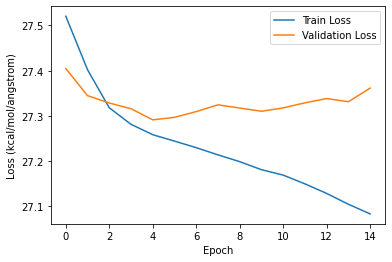

In [20]:
import pandas as pd

metrics = pd.read_csv("train/metrics.csv")

print(metrics)

# Here, we only are interested in the epochal train/validation losses,
# so we must filter the other non-epochal enetries in the logfile, which
# are recorded as NaNs
train_loss = metrics["training_loss"].to_numpy()
nan_idx = np.isnan(train_loss)
no_nan_idx = ~nan_idx
train_loss = train_loss[no_nan_idx]

val_loss = metrics["validation_loss"].to_numpy()
nan_idx = np.isnan(val_loss)
no_nan_idx = ~nan_idx
val_loss = val_loss[no_nan_idx]

plt.plot(train_loss, label="Train Loss")
plt.plot(val_loss, label="Validation Loss")
plt.ylabel("Loss (kcal/mol/angstrom)")
plt.xlabel("Epoch")
plt.legend(loc="best")
plt.show()

There are other useful files produced by the training routine. The first to note are are `ckpt` checkpoint files, which record the state of the model at the corresponding epoch. These can be reloaded for a continued or (possibly) different training routine at a future time. The second important file is `hparams.yaml`, which is a YAML file that stores the information about the hyperparemeters used to instantiate the model, the loss function, and the training routine.

# Using a Trained Model as a CG Force Field

With our model trained, we can use its ability to predict forces as a component of a CG molecular dynamics simulation. Currently, we implement Langevin and overdamped Langevin simulation schemes - here we will test the practical performance of our trained model using a Langevin simulation. 

In [21]:
SIM_PATH = osp.abspath("./simulate/")

input_config_fn = osp.join(SIM_PATH, "input_configurations.pt")
model_fn = osp.join(SIM_PATH, "model.pt")

!mkdir $SIM_PATH

## Setup the simulation

### Input configurations

Once the simulation has been set up, we must pass it a list of `AtomicData` containing the initial coordinates, atom types, and masses. For this demonstration, we select 10 random frames from the entire dataset. As mentioned in the beginning of this notebook, the prior CG forces were subtracted away from the full CG forces in order to train the network on the delta CG forces. In order to simulate physically meaningful results, our network model needs to be combined with the original priors to create the full force field - meaning we must make sure to supply our `AtomicData`s with the poper neighbor list for each prior so that features, such as bonds or angles, may be computed properly:


In [24]:
prior_nls = {}
for model in dataset.priors_cls:
    prior_nls.update(**model.neighbor_list(dataset.topologies['cln']))

full_idx = np.arange(len(dataset))
chosen_idx = np.random.choice(full_idx, 10)

initial_data_list = []
for idx in chosen_idx:
    data = dataset.get(idx)
    data.neighbor_list = prior_nls
    initial_data_list.append(data)
print(initial_data_list[0])

torch.save(initial_data_list, input_config_fn)

AtomicData(
  out={},
  pos=[10, 3],
  traj_id=[1],
  name='cln',
  frame_id=[1],
  atom_types=[10],
  n_atoms=[1],
  masses=[10],
  forces=[10, 3],
  neighbor_list={
    bonds={
      tag='bonds',
      order=2,
      index_mapping=[2, 9],
      cell_shifts=None,
      rcut=None,
      self_interaction=False,
      mapping_batch=[9]
    },
    angles={
      tag='angles',
      order=3,
      index_mapping=[3, 8],
      cell_shifts=None,
      rcut=None,
      self_interaction=False,
      mapping_batch=[8]
    },
    repulsion={
      tag='fully connected',
      order=2,
      index_mapping=[2, 90],
      cell_shifts=None,
      rcut=None,
      self_interaction=False,
      mapping_batch=[90]
    }
  }
)


### Model

To combine our network and prior models, we can use the `SumOut` class defined in `mlcg.nn.gradients`. `SumOut` aggregates the properties predicted in `AtomicData.out` over multiple models, allowing for multiple force terms that maybe represented by several networks or prior models. For simplicity, we use a helper method from `mlcg.pl` to produce our final model for simulation. In principle, `SumOut` can be used to combine arbitrary models together - once again taking advantage of the fact that the output of each model is stored individually in `AtomicData.out` by model name.

In [25]:
from mlcg.pl import merge_priors_and_checkpoint

try:
    model = merge_priors_and_checkpoint("train/last.ckpt", dataset.prior_models)
except FileNotFoundError:
    model = merge_priors_and_checkpoint(
        "train/ckpt/last.ckpt", dataset.prior_models
    )
print(model)

torch.save(model, model_fn)

SumOut(
  (models): ModuleDict(
    (SchNet): GradientsOut(
      (model): StandardSchNet(
        (embedding_layer): Embedding(44, 128)
        (rbf_layer): ExpNormalBasis(
          (cutoff): CosineCutoff()
        )
        (interaction_blocks): Sequential(
          (0): InteractionBlock(
            (conv): CFConv()
            (activation): Tanh()
            (lin): Linear(in_features=128, out_features=128, bias=True)
          )
          (1): InteractionBlock(
            (conv): CFConv()
            (activation): Tanh()
            (lin): Linear(in_features=128, out_features=128, bias=True)
          )
          (2): InteractionBlock(
            (conv): CFConv()
            (activation): Tanh()
            (lin): Linear(in_features=128, out_features=128, bias=True)
          )
        )
        (output_network): MLP(
          (layers): Sequential(
            (0): Linear(in_features=128, out_features=128, bias=True)
            (1): Tanh()
            (2): Linear(in_features

## Simulate

With the model and the initial configurations prepared, we are ready to run CG simulations. We choose the LangevinSimulation class defined in `mlcg.simulation`, for which we are free to adjust the inverse temperature, the integration timestep, etc. As with the training we can prepare the simulation explicitly or with the use CLI tools:

### In the notebook

In [26]:
from mlcg.simulation import LangevinSimulation

n_timesteps = 10000
save_interval = 10
export_interval = 1000
log_interval = 1000
dt = 0.004
friction = 1.0
beta = dataset.beta
filename = "simulate/cln_model"

simulation = LangevinSimulation(
    friction,
    dt=dt,
    beta=beta,
    n_timesteps=n_timesteps,
    save_interval=save_interval,
    export_interval=export_interval,
    log_interval=log_interval,
    filename=filename,
)

In [27]:
simulation.attach_configurations(initial_data_list)
simulation.attach_model(model)

print(f"Starting simulation at {ctime()}")
cg_traj = simulation.simulate()
print(f"Ending simulation at {ctime()}")
print("simulation output:", cg_traj.shape)

Starting simulation at Mon Mar 21 12:05:28 2022


Simulation timestep:   0%|          | 0/10000 [00:00<?, ?it/s]

Ending simulation at Mon Mar 21 12:11:16 2022
simulation output: (10, 1000, 10, 3)


We see that our output has a shape `(n_sims, n_saved_configurations, n_atoms, 3)`.With the training complete, our CG trajectory is ready for analysis via MDTraj or PyEmma tools. We suggest following the tutorials [Here](http://www.emma-project.org/latest/tutorials/notebooks/00-pentapeptide-showcase.html) for analyzing free energy surfaces for high dimensional systems. Instead, here we will simply inspect the CG trajectories using the NGLView plugin, which allows for simple molecular movie generation within a Jupyter notebook:

### With the CLI

In [ ]:
# A typical simulation input file
!cat ../inputs/langevin.yaml

In [ ]:
# which need to be adapted to your configuration
config = load_yaml("../inputs/langevin.yaml")
config["model_file"] = model_fn
config["structure_file"] = input_config_fn
config["simulation"]["filename"] = osp.join(SIM_PATH, "cln_model_cli")

config_fn = osp.join(SIM_PATH, "simulate.yaml")
dump_yaml(config_fn, config)

In [ ]:
!python ../../scripts/mlcg-nvt_langevin.py --config $config_fn

# Look at the trajectories

Lastly, we can look at each of the trajectories using the NGLview Jupyter notebook plugin:

In [29]:
import nglview as nv
from glob import glob
import mdtraj as md

In [30]:
cg_traj_fns = sorted(glob("simulate/*_coords_*"))
cg_trajs = [np.load(fn) for fn in cg_traj_fns]
cg_trajs = np.concatenate(cg_trajs, axis=1)
print("CG trajectories:", cg_trajs.shape)

CG trajectories: (10, 1000, 10, 3)


In [32]:
# if NGLview complains, you may need to update it or ask for a proper CG chignolin PDB file.
# Alternatively, you can reduce the pdb stored in the processed subdirectory of the data directory

mdtraj_topo = dataset.topologies['cln'].to_mdtraj()
chosen_trajectory = 0
cg_traj = md.Trajectory(
    cg_trajs[chosen_trajectory, :, :, :] / 10.0, mdtraj_topo
)  # divide by 10 to match the natural units of nm in NGLView
print(cg_traj)
cg_traj.superpose(cg_traj, frame=0)

t = nv.MDTrajTrajectory(cg_traj)
w = nv.NGLWidget(t)
w.parameters = {"backgroundColor": "white", "representation": "backbone"}
w.add_representation("licorice")
w

<mdtraj.Trajectory with 1000 frames, 10 atoms, 10 residues, without unitcells>


NGLWidget(max_frame=999)